In [1]:
from importlib import reload
import numpy as np
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from 'C:\\Users\\Andrew\\Documents\\mlprojects\\781-piano-autoencoder\\src\\ml_classes.py'>

In [33]:
with open('model_datas_non_sparse_base_key_03-04', 'wb') as f:
    pickle.dump(model_datas, f)
# for md in model_datas:
#     with open('training_data/' + md.name + 'v0', 'wb') as f:
#         pickle.dump(md.data, f)

In [8]:
model_datas = data.folder2examples('training_data\midi_val', sparse=True, use_base_key=True, beats_per_ex=8)
# with open('H2', 'wb') as f:
#     pickle.dump(mode_datas, f)

processing file 0 of 7
00h 38m 11s of data
(32, 88)
(32, 88)
(32, 88)
(32, 88)
(32, 2)
(12,)
(1,)
(1,)


## Model Construction
The 'model data' datatype provides information about inputs/outputs such as name, dimension, and whether or not it is sequential. So why this step here, using named tuples to provide information about inputs and outputs for model construction?  
Sometimes data is used as both input and output, and then a single label can't be applied. If data is not for an output, then activation is an irrelevant attribute.  
It probably maybe would still make sense to incorporate input/output and all other relevant info into the model data dtype, and then these *could* be passed into methods that construct models.

### Simple Bidirectional LSTM Network

Model: "simple_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
V_mean_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 32, 88)]     0                                            
__________________________________________________________________________________________________
repeat32Times (RepeatVector)    (None, 32, 1)        0           V_mean_in[0][0]                  
__________________________________________________________________________________________________
joinModelInput (Concatenate)    (None, 32, 89)       0           H_in[0][0]                       
                                                                 repeat32Times[0][0]    

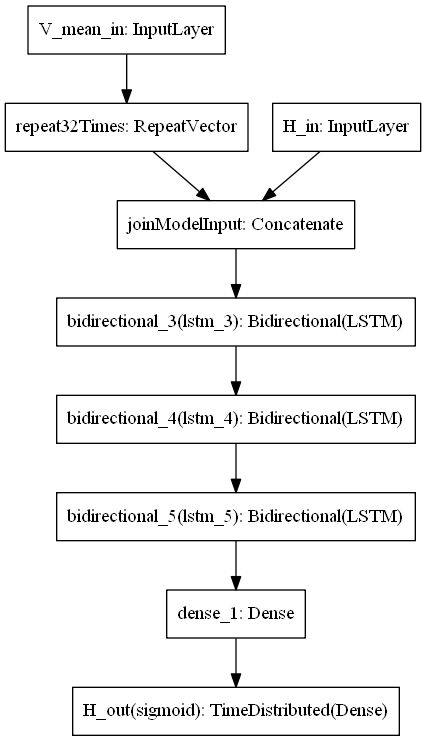

In [9]:
model_input_reqs, model_output_reqs = models.get_model_reqs(['H', 'V_mean'], ['H'])
seq_length = 32
seq_model = models.create_simple_LSTM_RNN(model_input_reqs, model_output_reqs, seq_length=seq_length)
seq_model.summary()
tf.keras.utils.plot_model(seq_model)

In [ ]:
import tensorflow.keras.backend as K
def mean_categorical_crossentropy(y_true, y_pred, from_logits=False):
    """calculates cc only for entries where a note exists
    
    Notes:
    If used with offsets, an offset COULD be zero!
    Looking at a few files, out of 9693 notes, this was true for 20 of them
    
    """
    indices = tf.where(y_true != 0)
    print(indices.shape)
    y_true_notes = K.cast(tf.gather_nd(y_true, indices), dtype='float32')
    y_pred_notes = K.cast(tf.gather_nd(y_pred, indices), dtype='float32')
    return tf.keras.losses.categorical_crossentropy(y_true_notes, y_pred_notes)

def logits_categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=False)

model_input_reqs, model_output_reqs = models.get_model_reqs(['H', 'V_mean'], ['H'])

for i, model_input in enumerate(model_input_reqs):
    print(f'input {i}: {model_input.name}')
          
for i, model_output in enumerate(model_output_reqs):
    print(f'out {i}: {model_output.name}')
dg = ml_classes.ModelDataGenerator([md for md in model_datas.values()],
                                   [model_in.name for model_in in model_input_reqs],
                                   [model_out.name for model_out in model_output_reqs],
                                    t_force=False, batch_size = 100, seq_length=seq_length)
seq_model.compile(optimizer='adam', loss=custom_categorical_crossentropy, metrics=['accuracy'])
history = seq_model.fit_generator(dg, epochs=5, verbose=1)

In [29]:
if type(loss) = note_categorical_crossentropy
note_categorical_crossentropy.__name__

'note_categorical_crossentropy'

### Simple LSTM encoder decoder

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
V_mean_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    (None, 64, 1)        0           V_mean_in[0][0]                  
__________________________________________________________________________________________________
joinModelInput (Concatenate)    (None, 64, 89)       0           H_in[0][0]                       
                                                                 repeat64Times[0][0]    

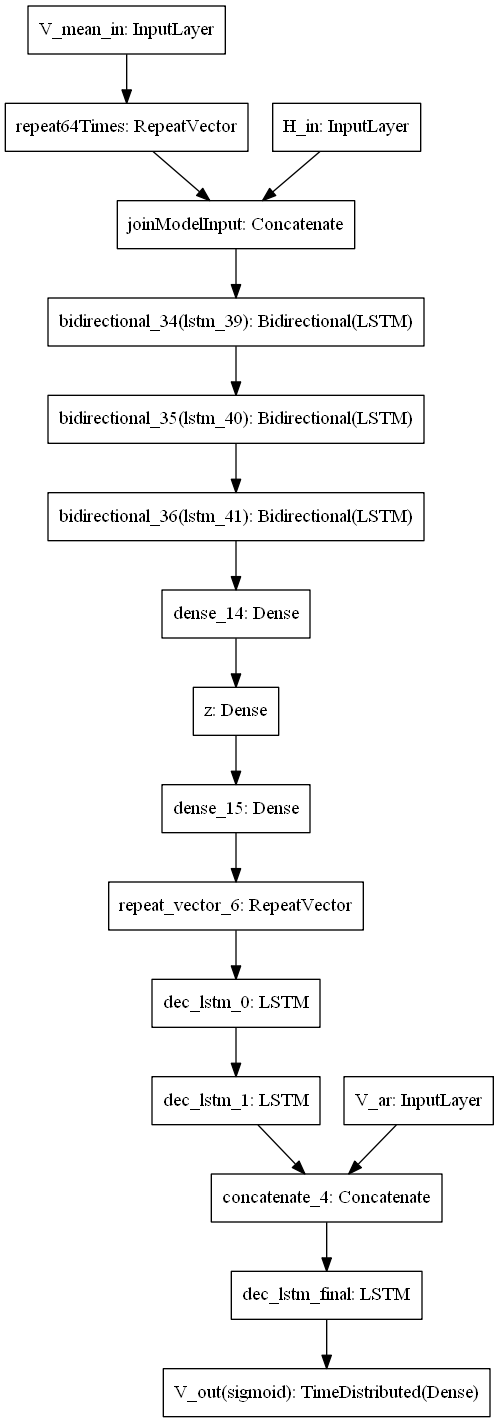

In [26]:
model_input_reqs, model_output_reqs = models.get_model_reqs(['H', 'V_mean'], ['V'])

seq_length=64

z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs)
pred, ar_inputs = models.create_LSTMdecoder_graph2(z, model_output_reqs, seq_length=seq_length, hidden_state_size = 64,
                    dense_size = 64)

autoencoder = tf.keras.Model(inputs=model_inputs + ar_inputs, outputs=pred, name=f'autoencoder')
autoencoder.summary()
tf.keras.utils.plot_model(autoencoder)

In [29]:
dg = ml_classes.ModelDataGenerator([md for md in model_datas.values()], [model_in.name for model_in in model_input_reqs], [model_out.name for model_out in model_output_reqs], batch_size = 30, seq_length=seq_length)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = autoencoder.fit_generator(dg, epochs=1, verbose=1)


15/15 [==============================] - 72s 5s/step - loss: 1.2444 - accuracy: 0.0078


### Hierarchical Encoder Decoder
Notice the need for the dummy input. This is because LSTMs operate for the number of time steps in the input - but there actually isn't any input for some of the LSTMs in this model.

conductor substeps: 8
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tempo_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
key_in (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 64, 88)]     0                                            
__________________________________________________________________________________________________
repeat64Times (RepeatVector)    multiple             0           tempo_in[0][0]                   
                                                                 key_i

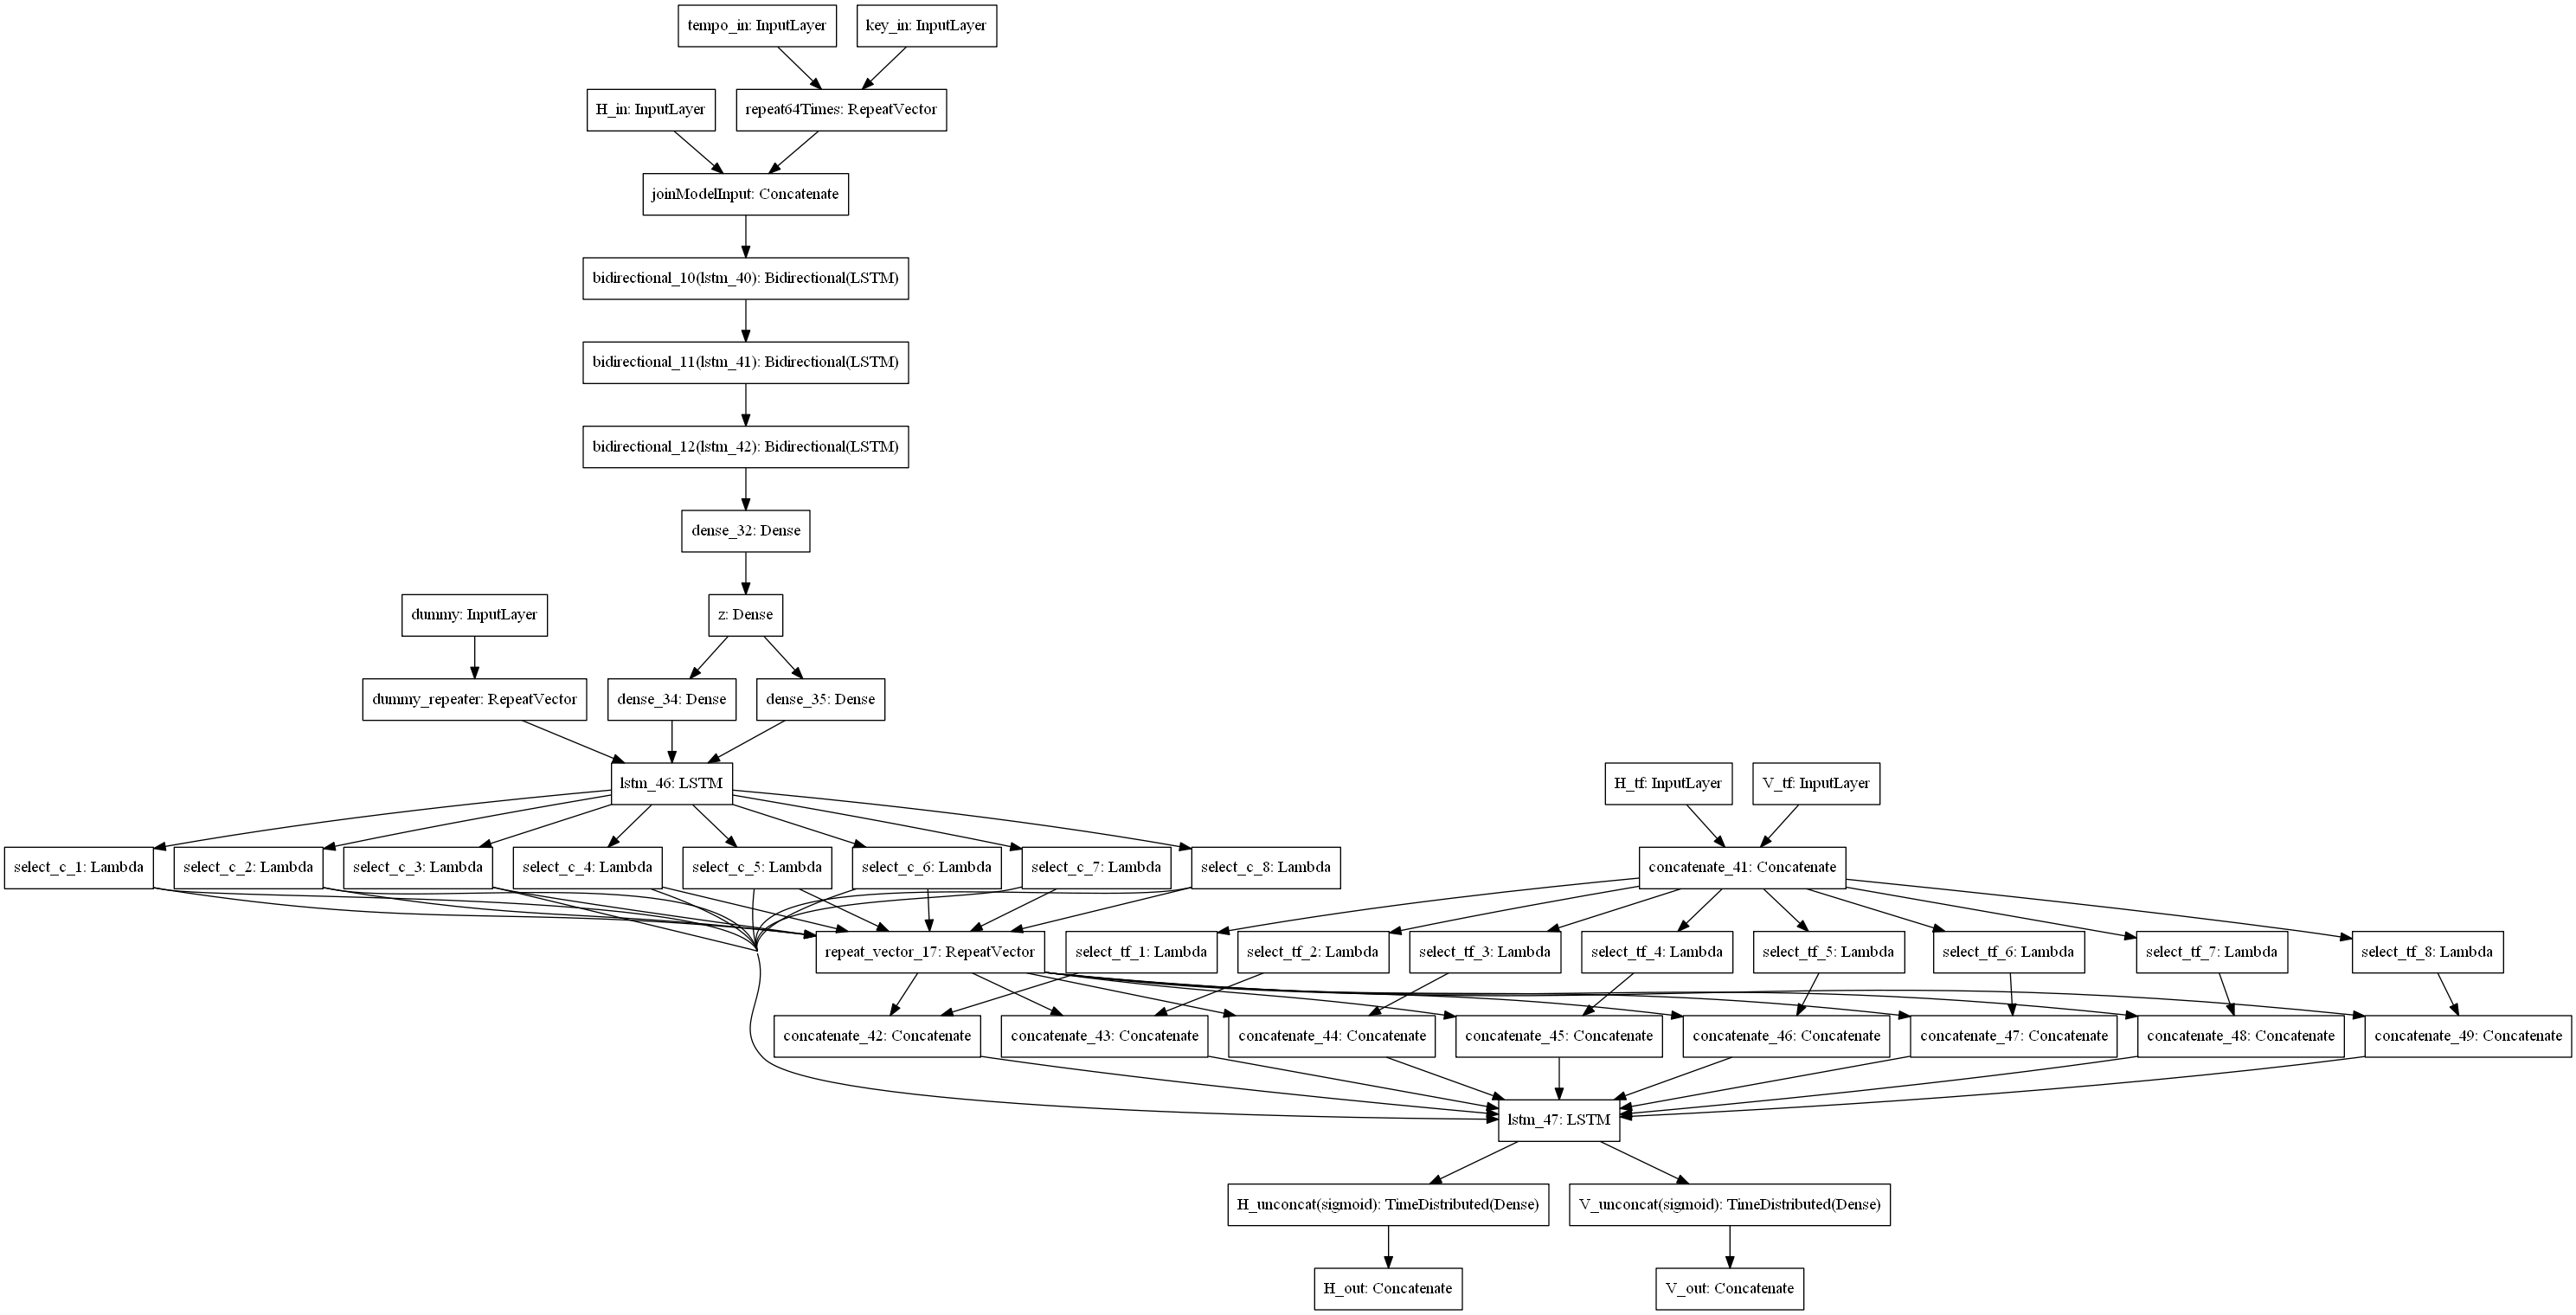

In [52]:
model_input_reqs, model_output_reqs = models.get_model_reqs(['H', 'V_mean'], ['V'])

z, model_inputs = models.create_LSTMencoder_graph(model_input_reqs)
dummy = tf.keras.Input(shape=[0], name='dummy')
outputs, extra_inputs = models.create_hierarchical_decoder_graph(z, model_output_reqs, dummy)
test_autoencoder = tf.keras.Model(inputs=model_inputs + extra_inputs, outputs=outputs)
test_autoencoder.summary()
tf.keras.utils.plot_model(test_autoencoder)

In [ ]:
# An autoencoder with separate encoder + decoder models might look like this:
inputA = tf.keras.Input((5,2), name='input_a')
outputA = layers.LSTM(5)(inputA)
modelA = tf.keras.Model(inputA, outputA)

inputB = tf.keras.Input(5, name='input_b')
outputB = layers.Dense(5)(inputB)
modelB = tf.keras.Model(inputB, outputB)

inputC = tf.keras.Input((5,2))
encoded = modelA(inputC)
decoded = modelB(encoded)
modelC = tf.keras.Model(inputC, decoded)
modelC.summary()